# Machine Learning Assignment I: Decision Trees


Group Details
1. 19CS30043 Shrinivas Khiste
2. 19CS10050 Rupinder Goyal

## Importing Libraries and Loading Data

In [106]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict


In [107]:
col_names = ["buying", "maint", "doors", "persons", "luggage_boot", "safety", "class value"]

In [108]:
df = pd.read_csv("car.data", names = col_names)
df.head()

,buying,maint,doors,persons,luggage_boot,safety,class value
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


# Gain Functions

## Utility Function

In [109]:
def getClassProportions(dataset):
  totalSize, _ = dataset.shape
  uniqueClassValues = dataset['class value'].unique()
  vals=defaultdict(int)
  for classvalue in uniqueClassValues:
     num, _ = dataset[ dataset['class value'] == classvalue].shape
     vals[classvalue]=num
  return vals,totalSize

## Gini Gain

In [163]:
# This Function calculates gini index for a child node
def gini_index_for_child(dataset):
  totalSize, _ = dataset.shape                         # size of the dataset
  uniqueClassValues = dataset['class value'].unique()  # unique class values
  giniIndex = 1                                        # initial value of gini index
  for classvalue in uniqueClassValues:
    p, _ = dataset[ dataset['class value'] == classvalue].shape     # p is the number of rows with the particular class value
    giniIndex = giniIndex - ( p / totalSize )  * ( p / totalSize )  # updating gini index

  return giniIndex                                      # returning gini index

# This Function calculates the value of gini index for an attribute
def gini_index(dataset, column_name):   
  totalSize, _ = dataset.shape         
  uniqueValues = dataset[column_name].unique() # unique column values 
  giniIndex = 0                                # Initial value of gini index
  split={}                                     # Saving the split info as a dictionary      
  for columnValue in uniqueValues:      
    _dataset = dataset[ dataset[column_name] == columnValue] # dataset with particular column value
    split[columnValue] = _dataset                            # Save it as a split 
    size, _ = _dataset.shape                                 
    giniValue = gini_index_for_child(_dataset)               # finding the gini_value for the child
    giniIndex = giniIndex + size/ totalSize * giniValue      # updating gini index 

  return giniIndex,split

# This Function calculates split for a node
def bestSplitGiniIndex(dataset):
  columns = dataset.columns            # all columns
  columns = columns[:-1]               # do not consider the class value 
  best_split={}                        # To save the best split
  best_gini=999                        # To save the best gini index
  spit_column = None                   # To save the attribute that leads to the best split
  for column in columns:
    gini,split = gini_index(dataset, column)  # find gini_index with the particular column value
    if(gini<best_gini):                # if gini index is better then save 
      split_column= column
      best_gini = gini
      best_split = split          
  node={}                              # return the results as a decision tree node in the form of a dictionary
  node['column']=split_column
  node['gain']=best_gini
  node['split']=best_split
  node['isTerminal'] = False
  node['class wise composition'],node['sample size']=getClassProportions(dataset)
  return node

## Information Gain

In [164]:
# Function to calculate the entropy for a child node dataset
def entropy(dataset):
  entropyValue = 0                  # Initialising the entropy value to zero
  totalSize, _ = dataset.shape      # Number of rows in the dataset
  uniqueClassValues = dataset['class value'].unique()  # Unique class Values in the dataset
  for classValue in uniqueClassValues:          
    p, _ = dataset[dataset['class value'] == classValue].shape  # Number of rows with particular class value
    p = p / totalSize                                           # probability 
    entropyValue = entropyValue - p * math.log(p,2)             # updating entropy

  return entropyValue

# Function to calculate value of information gain for an attribute
def information_gain(dataset, column_name):
  uniqueValues = dataset[column_name].unique()       # unique values of the column
  totalSize, _ = dataset.shape                       # size of the dataset
  infoGain = entropy(dataset)                        # initial infoGain ( parent entropy value)
  split={}                      
  for value in uniqueValues:                              # dividing for each value of the column
    _dataset = dataset[dataset[column_name] == value]     # dataset with the particular column value
    split[value] = _dataset
    size, _ = _dataset.shape                              # size of the splitted dataset
    entropyVal = entropy( _dataset)                       # Entropy of the splitted dataset
    infoGain = infoGain - size/ totalSize * (entropyVal)  # updating infoGain
  return infoGain,split

# Function to calculate best split according to information gain
def bestSplitInfoGain(dataset):
  Columns = dataset.columns     # columns to be considered for splitting
  Columns = Columns[:-1]        # do not consider class value
  infoGain = []                 # it stores infogain for each column
  split_column=None             # To save the attribute that leads to the best split
  best_split={}                 # To save the best split
  best_gain = 0                 # To save the best information gain
  for column in Columns:        
    currInfoGain,split = information_gain(dataset, column)  #finding the info gain for the particular column
    if(best_gain<currInfoGain): # If gain is better then save
      best_gain=currInfoGain
      best_split=split
      split_column = column
  node={}                       # return the results as a decision tree node in the form of a dictionary
  node['column']=split_column
  node['gain']=best_gain
  node['split']=best_split
  node['isTerminal'] = False
  node['class wise composition'],node['sample size']=getClassProportions(dataset)
  return node

# Building a tree

In [166]:
# Function to create and return a terminal node 
def terminal_node(dataset, columnValue, parent):
  node={}
  node['columnValue']=columnValue
  node['subtree size'] = 1
  node['parent'] = parent
  node['gain']=-1
  node['split']=[]
  node['isTerminal']=True
  node['class wise composition'],node['sample size']=getClassProportions(dataset)

  node['prediction'] = max(node['class wise composition'],key=lambda x: node['class wise composition'][x])
  
  return node

In [167]:
# Function to check if the data of the split corresponds to a pure leaf node
# This is when all the class values in the data are the same
def pure_leaf(data):
  values = data['class value'].unique()
  if len(values) == 1:
    return True
  return False

In [168]:
# Function to split the node recursively
def split(data,depth, MaxDepth = None, criterion = "gini", columnValue = None, parent = None):
  if (pure_leaf(data) == True):                           # check if it is a pure leaf
    return terminal_node(data, columnValue, parent) , 1   # return terminal node
  if (MaxDepth != None and depth == MaxDepth):            # check if max depth is reached
    return terminal_node(data, columnValue, parent) , 1   # return terminal node
  if criterion == "gini":                                 # get best split for gini gain
    node = bestSplitGiniIndex(data)
  elif criterion == "entropy":                            # get best split for entropy gain
    node = bestSplitInfoGain(data)
  else:                                                   # raise Exception if criteria is not valid
    raise Exception("Criterion Is not valid.")
  node['parent'] = parent                                 # save parent 
  node['columnValue'] = columnValue                       # save column value
  node['isTerminal']=False                                # save node whether it is terminal or not 
  child_nodes={}  
  subTreeSize = 1
  for value, child in node['split'].items():              # for all the data splits create a child node
    if(len(child)==0):                                    # do not consider splits that have zero length
      continue
    child_node, size = split(child,depth+1 ,MaxDepth,criterion,value, node)    # split child node too
    child_nodes[value] = child_node                                   # save it as a child
    subTreeSize = subTreeSize + size                                  # maintain size
  node['subtree size'] = subTreeSize                                  # save size
  node['children']=child_nodes                                        # save child nodex

  return node , subTreeSize 

In [169]:
# Main Function to build the Tree
def build_tree(data, MaxDepth = None, criterion = "gini"):
  root , size  = split(data,0, MaxDepth,criterion)
  return root

## Function To Print Tree

In [170]:
# Function to print the decision tree formed
def printTree(root, depth = 0):
  if(root['isTerminal']):         # if node is terminal then end
    print("\t"*depth+"Prediction: ",root['prediction'])
    return
  print("\t"*depth+"Column: "+root['column'],", Gain: "+str(root['gain']),", Samples: "+str(root['sample size']))
  for value, child in root['children'].items():     # else print for each child
    print("\t"*depth + root['column'] + " == " + value + ": ")
    printTree(child,depth+1)

# Prediction & Accuracy Functions


In [171]:
def predict(root, data):
  prediction = pd.Series(dtype='float64')
  for i, row in data.iterrows():
    node = root
    prediction.at[i] = None
    while node['gain'] != -1:  # Terminal Node
      col = node['column']
      if row[col] not in node['children']: # child not available
        prediction.at[i] = max(zip(node['class wise composition'].values(), node['class wise composition'].keys()))[1]
        break
      node = node['children'][row[col]]
    if prediction[i] == None:
      prediction.at[i] = node['prediction']
  return prediction

def accuracy(root, data):
  predValues = predict(root,data)
  actualValues = data['class value']
  totalSize = predValues.size
  count = predValues.eq(actualValues).value_counts().to_dict()[True]
  acc = count/ totalSize
  return acc

# Pruning Functions

In [118]:
# Function to get all the nodes whose all children are terminals of a decision tree
def getTerminalPars(root):
  terminalparents = []
  Par = True
  for value,child in root['children'].items(): # else add terminal nodes of all children
    if child['isTerminal']:
      continue
    Par = False
    child_terminalpars = getTerminalPars(child)
    terminalparents.extend(child_terminalpars)
  if Par:
    terminalparents.append(root)
  return terminalparents

In [119]:
# Function to prune the tree using Chi-squared statistical test
uniqueClassValues = df['class value'].unique()
ChiSquared = {1: 3.84, 2: 5.99, 3: 7.81, 4: 9.49, 5: 11.07, 6: 12.59, 7: 14.07, 8: 15.51, 9: 16.92, 10: 18.31}
def pruneTreeStatisticalMethod(root):
  while True:
    terminalpars = getTerminalPars(root)
    updated = False
    for index, terminalpar in enumerate(terminalpars):
      K = 0
      for value, child in terminalpar['children'].items():
        Pj = child['sample size']/terminalpar['sample size']
        for classValue in uniqueClassValues:

          Ni = terminalpar['class wise composition'][classValue]
          Ndij = Ni * Pj
          if Ndij == 0:
            continue
          Nij = child['class wise composition'][classValue]
          K = K + (Nij - Ndij) * (Nij - Ndij) / Ndij
      df = (len(terminalpar['children']) - 1) * 3

      if K < ChiSquared[df] :
        updated = True
        print("Pruned Children of Node with split column as "+ terminalpar['columnValue'])
        terminalpar['children'].clear()
        terminalpar['isTerminal'] = True
        terminalpar['prediction'] = max(terminalpar['class wise composition'],key=lambda x: terminalpar['class wise composition'][x])
        
    if updated == False:
      break

  return root

In [159]:
# Function get all the terminal nodes of a decision tree
def getTerminals(root):
  terminals = []
  if(root['isTerminal']):                       # if node is terminal add to list and return
    terminals.append(root)
    return terminals
  for value,child in root['children'].items(): # else add terminal nodes of all children
    child_terminals = getTerminals(child)
    terminals.extend(child_terminals)
  return terminals

In [160]:
# Function to prune the tree according to test data
def pruneTreeCV(root,data):
  curr_acc = accuracy(root,data)
  while True:
    terminals = getTerminals(root)

    best_acc=0
    best_index=0

    for index, terminal in enumerate(terminals):
      # temporarily remove it
      parent = terminal['parent']
      del parent['children'][terminal['columnValue']]

      # get accuracy
      temp_acc = accuracy(root,data)

      if temp_acc > best_acc:
        best_index = index
        best_acc = temp_acc
      
      # restore it
      parent['children'][terminal['columnValue']]=terminal

    if best_acc > curr_acc:     # if accuracy increases then prune permanently
      print("Accuracy Improved (" + str(curr_acc) + " to " + str(best_acc) + "). Permanent Pruning")
      curr_acc =best_acc
      # permanantly delete it 
      terminal = terminals[best_index]
      parent = terminal['parent']
      print("Removing Terminal Column Value: "+ terminal['columnValue']+" Parent Column: "+parent['column'])
      del parent['children'][terminal['columnValue']]
      
      # if all the children get pruned, mark it as terminal 
      if not parent['children']:
        parent['isTerminal'] = True
      if len(parent['children'])==0:
        parent['isTerminal']=True
    else:     # if accuracy has not increased then break
      break
  print("Final Accuracy: ",curr_acc)
  return root,curr_acc

# Questions

## 1. Random 80/20 split and building the tree

In [143]:
df_train, df_test = train_test_split(df,test_size=0.2)			

In [144]:
df_train.head()

,buying,maint,doors,persons,luggage_boot,safety,class value
429,vhigh,low,5more,more,big,low,unacc
504,high,vhigh,4,more,small,low,unacc
1505,low,high,5more,more,small,high,acc
1686,low,low,4,4,med,low,unacc
423,vhigh,low,5more,more,small,low,unacc


In [145]:
root_entropy = build_tree(df_train, criterion = "entropy")

In [146]:
accuracy(root_entropy, df_test)

0.9190751445086706

In [147]:
root_gini = build_tree(df_train, criterion = "gini")

In [148]:
accuracy(root_gini, df_test)

0.9161849710982659

## 2. Average accuracy over 10 80/20 splits 

In [149]:
def run_for_10_splits(df,criterion):
  avg_acc = 0
  best_acc = 0
  best_tree = None
  best_df_train = None
  best_df_test = None
  for i in range(10):
    df_train, df_test = train_test_split(df,test_size=0.2)
    root = build_tree(df_train,criterion)
    acc = accuracy(root,df_test)

    print("Iteration : "+str(i+1)+" Accuracy: "+str(acc))
    avg_acc+=acc
    if acc > best_acc:
      best_acc = acc
      best_df_train = df_train
      best_df_test = df_test
      best_tree = root

  print("\nAverage Accuracy: "+str(avg_acc/10))
  print("Best Accuracy: "+str(best_acc))
  return avg_acc,best_acc, best_df_train, best_df_test, best_tree

### Gini Index

In [150]:
avg_acc_gini,best_acc_gini, best_df_train_gini, best_df_test_gini,best_tree_gini = run_for_10_splits(df,"gini")

Iteration : 1 Accuracy: 0.9566473988439307
Iteration : 2 Accuracy: 0.9450867052023122
Iteration : 3 Accuracy: 0.9248554913294798
Iteration : 4 Accuracy: 0.9248554913294798
Iteration : 5 Accuracy: 0.9104046242774566
Iteration : 6 Accuracy: 0.9335260115606936
Iteration : 7 Accuracy: 0.9190751445086706
Iteration : 8 Accuracy: 0.9364161849710982
Iteration : 9 Accuracy: 0.9335260115606936
Iteration : 10 Accuracy: 0.9248554913294798

Average Accuracy: 0.9309248554913294
Best Accuracy: 0.9566473988439307


### Information Gain

In [151]:
avg_acc_entropy ,best_acc_entropy, best_df_train_entropy, best_df_test_entropy, best_tree_entropy = run_for_10_splits(df,"entropy")

Iteration : 1 Accuracy: 0.9190751445086706
Iteration : 2 Accuracy: 0.9075144508670521
Iteration : 3 Accuracy: 0.930635838150289
Iteration : 4 Accuracy: 0.9219653179190751
Iteration : 5 Accuracy: 0.8901734104046243
Iteration : 6 Accuracy: 0.9335260115606936
Iteration : 7 Accuracy: 0.9075144508670521
Iteration : 8 Accuracy: 0.9046242774566474
Iteration : 9 Accuracy: 0.930635838150289
Iteration : 10 Accuracy: 0.9393063583815029

Average Accuracy: 0.9184971098265894
Best Accuracy: 0.9393063583815029


We can see that Information Gain gives a better average and best accuracy over the 10 runs

### Storing tree with maximum accuracy

In [157]:
if best_acc_gini < best_acc_entropy:
  grow_data = best_df_train_entropy
  validation_data = best_df_test_entropy
  best_tree = best_tree_entropy
else:
  grow_data = best_df_train_gini
  validation_data = best_df_test_gini
  best_tree = best_tree_gini

## 3. Best Possible Depth Limit

### Using Gini Index

Text(5, 0.9464161849710983, '(5, 0.94)')

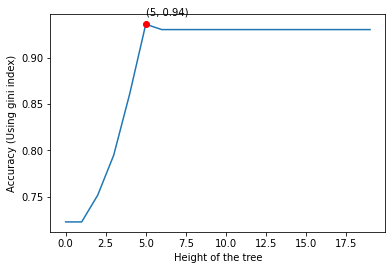

In [138]:
values = [i for i in range(20)]
df = df.sample(frac = 1)
x = int (0.8 * df.shape[0] )
train_data = df[: x]
test_data = df[ x : ]
accuracies = []
for i in values:
  root = build_tree(train_data, i)
  accuracyy = accuracy(root, test_data)
  accuracies.append(accuracyy)
xmax = values[accuracies.index(max(accuracies))]
ymax = max(accuracies)
plt.plot(values, accuracies)
plt.xlabel("Height of the tree")
plt.ylabel("Accuracy (Using gini index)")
plt.plot(xmax, ymax, 'ro')
plt.text(xmax, ymax + 0.01, "({}, {})".format(xmax, round(ymax, 2)))

### Using Information Gain

Text(5, 0.9406358381502891, '(5, 0.93)')

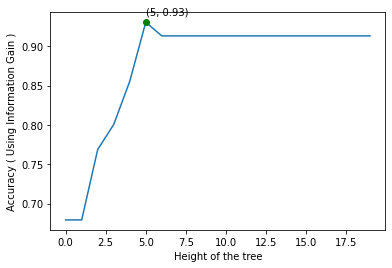

In [139]:
values = [i for i in range(20)]
df = df.sample(frac = 1)
x = int (0.8 * df.shape[0] )
train_data = df[: x]
test_data = df[ x : ]
accuracies = []
for i in values:
  root = build_tree(train_data, i, criterion = "entropy")
  accuracyy = accuracy(root, test_data)
  accuracies.append(accuracyy)
xmax = values[accuracies.index(max(accuracies))]
ymax = max(accuracies)
plt.plot(values, accuracies)
plt.xlabel("Height of the tree")
plt.ylabel("Accuracy ( Using Information Gain )")
plt.plot(xmax, ymax, 'go')
plt.text(xmax, ymax + 0.01, "({}, {})".format(xmax, round(ymax, 2)))

### 3.2 Plot: Accuracy vs Number of Nodes 

#### Using Gini Index

Text(208, 0.9232947976878613, '(208, 0.91)')

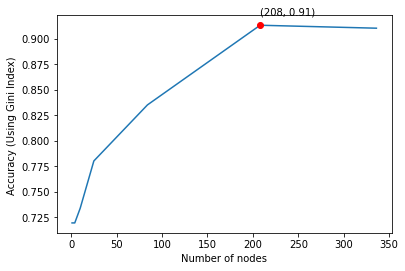

In [140]:
values = []
accuracies = []
df = df.sample(frac = 1)
x = int (0.8 * df.shape[0] )
train_data = df[: x]
test_data = df[ x : ]
for i in range(20):
  root = build_tree(train_data, i)
  accuracyy = accuracy(root, test_data)
  values.append(root['subtree size'])
  accuracies.append(accuracyy)
xmax = values[accuracies.index(max(accuracies))]
ymax = max(accuracies)
plt.plot(values, accuracies)
plt.xlabel("Number of nodes")
plt.ylabel("Accuracy (Using Gini Index) ")
plt.plot(xmax, ymax, 'ro')
plt.text(xmax, ymax + 0.01, "({}, {})".format(xmax, round(ymax, 2)))

#### Using Entropy

Text(214, 0.9435260115606936, '(214, 0.93)')

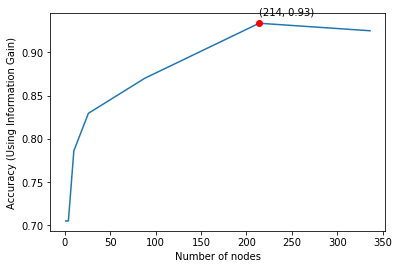

In [141]:
values = []
accuracies = []
df = df.sample(frac = 1)
x = int (0.8 * df.shape[0] )
train_data = df[: x]
test_data = df[ x : ]
for i in range(20):
  root = build_tree(train_data, i, criterion = "entropy")
  accuracyy = accuracy(root, test_data)
  values.append(root['subtree size'])
  accuracies.append(accuracyy)
xmax = values[accuracies.index(max(accuracies))]
ymax = max(accuracies)
plt.plot(values, accuracies)
plt.xlabel("Number of nodes")
plt.ylabel("Accuracy (Using Information Gain)")
plt.plot(xmax, ymax, 'ro')
plt.text(xmax, ymax + 0.01, "({}, {})".format(xmax, round(ymax, 2)))

## 4. Pruning the Tree

In [153]:
newRoot = pruneTreeStatisticalMethod(best_tree)

Pruned Children of Node with split column as med
Pruned Children of Node with split column as med
Pruned Children of Node with split column as med
Pruned Children of Node with split column as med
Pruned Children of Node with split column as med
Pruned Children of Node with split column as 2
Pruned Children of Node with split column as 2
Pruned Children of Node with split column as 2
Pruned Children of Node with split column as med
Pruned Children of Node with split column as small
Pruned Children of Node with split column as small
Pruned Children of Node with split column as med
Pruned Children of Node with split column as 2
Pruned Children of Node with split column as 2
Pruned Children of Node with split column as small
Pruned Children of Node with split column as med
Pruned Children of Node with split column as small
Pruned Children of Node with split column as med
Pruned Children of Node with split column as small
Pruned Children of Node with split column as med
Pruned Children of N

In [156]:
accuracy(newRoot, validation_data)

0.9017341040462428

In [175]:
newCvroot = pruneTreeCV(best_tree, validation_data)
acc = accuracy(newRoot, validation_data)
print(acc)

Final Accuracy:  0.9190751445086706
0.9190751445086706


## 5. Print the test with maximum Accuracy

In [ ]:
printTree(best_tree)

Column: safety , Gain: 0.38142868469429725 , Samples: 1382
safety == high: 
	Column: persons , Gain: 0.43791646147529195 , Samples: 461
	persons == more: 
		Column: buying , Gain: 0.5558199991178583 , Samples: 155
		buying == high: 
			Column: maint , Gain: 0.0946305156831473 , Samples: 38
			maint == vhigh: 
				Prediction:  unacc
			maint == low: 
				Prediction:  acc
			maint == high: 
				Prediction:  acc
			maint == med: 
				Prediction:  acc
		buying == med: 
			Column: maint , Gain: 0.3454545454545455 , Samples: 41
			maint == med: 
				Prediction:  vgood
			maint == vhigh: 
				Prediction:  acc
			maint == high: 
				Prediction:  acc
			maint == low: 
				Prediction:  vgood
		buying == vhigh: 
			Column: maint , Gain: 0.09324009324009329 , Samples: 39
			maint == high: 
				Prediction:  unacc
			maint == med: 
				Prediction:  acc
			maint == vhigh: 
				Prediction:  unacc
			maint == low: 
				Prediction:  acc
		buying == low: 
			Column: maint , Gain: 0.41966966966966973 , Sa